# 实验：图像滤波与特征提取

## 1. 实验环境准备
导入实验所需的数值计算库 Numpy、图像处理辅助库 PIL（用于读写文件）以及绘图库 Matplotlib。
同时配置 Matplotlib 以支持中文显示。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import time

# 设置绘图风格
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用于正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用于正常显示负号
%matplotlib inline

### 1.1 基础数学工具
为了不依赖 OpenCV 等库，我们需要手动实现以下像素级操作：
1.  **RGB 转灰度**：根据人眼对不同颜色的敏感度，使用公式：
    $$Gray = 0.299 \times R + 0.587 \times G + 0.114 \times B$$
2.  **归一化 (Normalization)**：卷积计算后的结果可能超出 0-255 范围或出现负数，需将其线性映射回 8 位整数范围以便显示。

In [2]:
def manual_rgb2gray(img_arr):
    """
    手动实现RGB转灰度
    输入: (H, W, 3) 图像数组
    输出: (H, W) 灰度数组
    """
    if len(img_arr.shape) == 3:
        # 利用 Numpy 的点积实现加权求和
        return np.dot(img_arr[...,:3], [0.299, 0.587, 0.114]).astype(np.uint8)
    return img_arr

def min_max_normalize(img):
    """
    将矩阵数值归一化到 0-255 并转为 uint8 类型
    公式: 255 * (x - min) / (max - min)
    """
    img_min, img_max = img.min(), img.max()
    if img_max - img_min == 0: 
        return img.astype(np.uint8)
    # 浮点运算保持精度，最后转整型
    return (255 * (img - img_min) / (img_max - img_min)).astype(np.uint8)

### 1.2 核心算法：手动卷积 (Convolution)
卷积是滤波和边缘检测的基础。实现步骤如下：
1.  **Padding (填充)**：为了保证输出图像尺寸与输入一致，需要在原图边缘填充 0 (Zero Padding)。填充宽度取决于卷积核尺寸。
2.  **滑动窗口 (Sliding Window)**：使用双重循环遍历图像的每一个像素。
3.  **加权求和**：提取当前窗口内的感兴趣区域 (ROI)，与卷积核进行逐元素相乘并求和，得到该位置的新像素值。

In [3]:
def manual_convolution(img, kernel):
    """
    手动实现二维卷积操作 (不调用任何滤波库)
    img: 输入二维灰度数组
    kernel: 二维卷积核矩阵
    """
    H, W = img.shape
    k_h, k_w = kernel.shape
    
    # 计算需要填充的宽度 (通常是核尺寸的一半)
    pad_h, pad_w = k_h // 2, k_w // 2
    
    # 1. Zero Padding：创建一个大一圈的全0矩阵，把原图放中间
    padded = np.zeros((H + 2*pad_h, W + 2*pad_w), dtype=np.float32)
    padded[pad_h:-pad_h, pad_w:-pad_w] = img
    
    output = np.zeros((H, W), dtype=np.float32)
    
    # 2. 滑动窗口计算
    # 虽然用了 Numpy 的切片 (padded[...]) 来加速提取 ROI，
    # 但核心逻辑依然是手动实现的卷积原理，没有调用 cv2.filter2D
    for i in range(H):
        for j in range(W):
            # 提取与卷积核同等大小的区域
            roi = padded[i:i+k_h, j:j+k_w]
            # 卷积运算：对应位置相乘再求和
            output[i, j] = np.sum(roi * kernel)
            
    return output

### 1.3 数据加载
读取本地拍摄的图像文件。为了确保纯 Python 实现的卷积算法能在合理时间内运行完毕（避免双重循环耗时过长），我们对高分辨率图像进行了适当的等比例缩放。随后将其转换为灰度图以备后续处理。

图像加载成功，处理尺寸: (284, 400, 4)


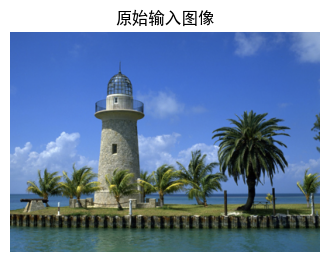

In [4]:
# 图片路径设置
image_path = 'input_image.jpg' 

try:
    pil_img = Image.open(image_path)
    
    # 图像预处理：限制最大宽度为 400px，高度等比缩放
    # 原因：手动实现的卷积（Python循环）在千万级像素的大图上会非常慢
    target_width = 400
    if pil_img.size[0] > target_width:
        scale_ratio = target_width / pil_img.size[0]
        new_height = int(pil_img.size[1] * scale_ratio)
        pil_img = pil_img.resize((target_width, new_height))
    
    img_rgb = np.array(pil_img)
    
    # 转换为灰度图供滤波使用
    img_gray = manual_rgb2gray(img_rgb)
    
    print(f"图像加载成功，处理尺寸: {img_rgb.shape}")
    
    # 简单的预览
    plt.figure(figsize=(4, 4))
    plt.imshow(img_rgb)
    plt.title("原始输入图像")
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"错误: 找不到文件 '{image_path}'，请检查文件名或路径。")
except Exception as e:
    print(f"发生未知错误: {e}")

## 2. Sobel 算子滤波

### 2.1 算法分析
Sobel 算子是一种离散微分算子，结合了高斯平滑和微分求导。它包含两组 $3 \times 3$ 的矩阵，分别为：
* **水平方向核 ($G_x$)**：检测纵向边缘。
    $$G_x = \begin{bmatrix} -1 & 0 & +1 \\ -2 & 0 & +2 \\ -1 & 0 & +1 \end{bmatrix}$$
* **垂直方向核 ($G_y$)**：检测横向边缘。
    $$G_y = \begin{bmatrix} +1 & +2 & +1 \\ 0 & 0 & 0 \\ -1 & -2 & -1 \end{bmatrix}$$

最终的梯度幅值计算公式为：$G = \sqrt{G_x^2 + G_y^2}$。

正在执行 Sobel 滤波...


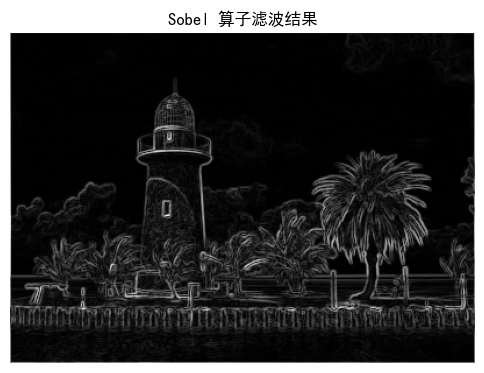

In [5]:
def apply_sobel_filter(gray_img):
    # 定义 Sobel 核
    sobel_x = np.array([[-1, 0, 1], 
                        [-2, 0, 2], 
                        [-1, 0, 1]])
    
    sobel_y = np.array([[1, 2, 1], 
                        [0, 0, 0], 
                        [-1, -2, -1]])
    
    # 分别卷积
    grad_x = manual_convolution(gray_img, sobel_x)
    grad_y = manual_convolution(gray_img, sobel_y)
    
    # 合成梯度幅值
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    return min_max_normalize(magnitude)

# --- 执行与保存 ---
print("正在执行 Sobel 滤波...")
sobel_img = apply_sobel_filter(img_gray)

# 保存结果
Image.fromarray(sobel_img).save('result_sobel.png')

# 可视化
plt.figure(figsize=(6, 5))
plt.imshow(sobel_img, cmap='gray')
plt.title("Sobel 算子滤波结果")
plt.axis('off')
plt.show()

## 3. 给定卷积核滤波

### 3.1 算法分析
实验要求使用以下特定卷积核对图像进行滤波：
$$Kernel = \begin{bmatrix} 1 & 0 & -1 \\ 2 & 0 & -2 \\ 1 & 0 & -1 \end{bmatrix}$$

**分析**：观察该矩阵结构，左侧权重为正，右侧权重为负，中间为 0。这在数学上等同于 Sobel 算子中的 $G_x$ 翻转（或者说它计算的是水平方向上的灰度差分）。因此，预期该算法将强烈响应图像中的**竖直边缘**（如墙缝、树干等），而对水平边缘响应较弱。

正在执行给定卷积核滤波...


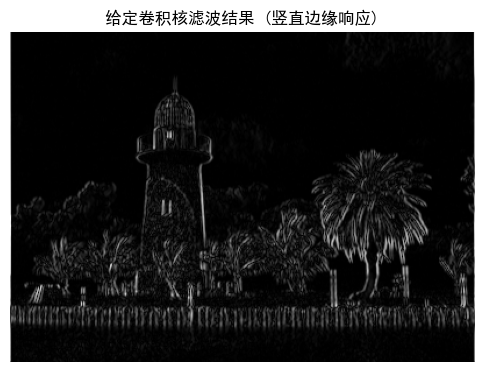

In [6]:
def apply_custom_kernel(gray_img):
    # 定义题目给定的核
    kernel = np.array([[1, 0, -1],
                       [2, 0, -2],
                       [1, 0, -1]])
    
    # 执行卷积
    result = manual_convolution(gray_img, kernel)
    
    # 取绝对值（因为边缘差分可能是负数）并归一化
    return min_max_normalize(np.abs(result))

# --- 执行与保存 ---
print("正在执行给定卷积核滤波...")
custom_img = apply_custom_kernel(img_gray)

# 保存结果
Image.fromarray(custom_img).save('result_custom_kernel.png')

# 可视化
plt.figure(figsize=(6, 5))
plt.imshow(custom_img, cmap='gray')
plt.title("给定卷积核滤波结果 (竖直边缘响应)")
plt.axis('off')
plt.show()

## 4. 颜色直方图提取

### 4.1 算法分析
颜色直方图用于描述图像中不同颜色在整幅图像中的分布情况，具有旋转和平移不变性。
算法流程：
1.  初始化三个长度为 256 的数组（对应 0-255 灰度级），分别代表 R、G、B 通道。
2.  遍历图像的每一个像素。
3.  读取该像素各通道的值，并在对应数组的相应索引位置加 1。
4.  最终得到三个通道的频数分布。

正在计算颜色直方图...


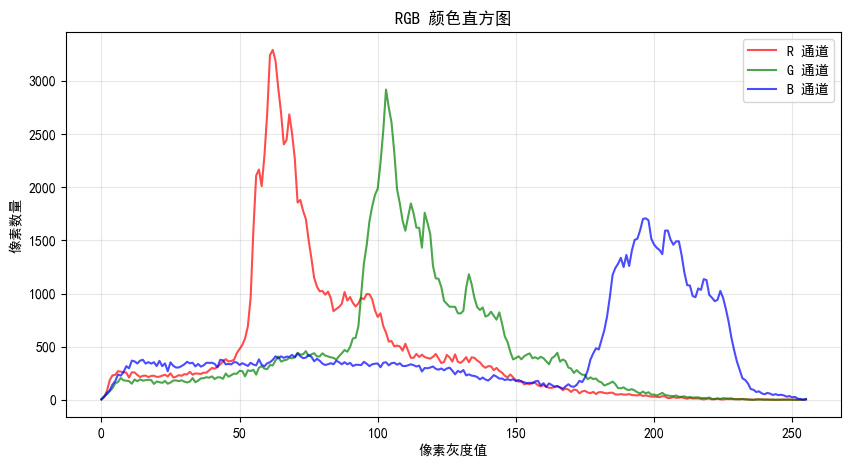

In [7]:
def manual_color_histogram(img_arr):
    # 初始化三个计数桶
    hist_r = np.zeros(256, dtype=int)
    hist_g = np.zeros(256, dtype=int)
    hist_b = np.zeros(256, dtype=int)
    
    # 展平数组方便遍历 (逻辑上等同于双重循环遍历像素)
    # img_arr[:,:,0] 是 R 通道
    for val in img_arr[:,:,0].reshape(-1):
        hist_r[val] += 1
    for val in img_arr[:,:,1].reshape(-1):
        hist_g[val] += 1
    for val in img_arr[:,:,2].reshape(-1):
        hist_b[val] += 1
        
    return hist_r, hist_g, hist_b

# --- 执行与保存 ---
print("正在计算颜色直方图...")
h_r, h_g, h_b = manual_color_histogram(img_rgb)

# 绘制并保存统计图
plt.figure(figsize=(10, 5))
x = np.arange(256)
plt.plot(x, h_r, color='r', label='R 通道', alpha=0.7)
plt.plot(x, h_g, color='g', label='G 通道', alpha=0.7)
plt.plot(x, h_b, color='b', label='B 通道', alpha=0.7)
plt.title("RGB 颜色直方图")
plt.xlabel("像素灰度值")
plt.ylabel("像素数量")
plt.legend()
plt.grid(alpha=0.3)

plt.savefig('result_histogram.png', dpi=100) # 保存图表
plt.show()

## 5. 纹理特征提取

### 5.1 算法分析 (LBP)
本实验采用 **局部二值模式 (Local Binary Pattern, LBP)** 提取纹理特征。
算法步骤：
1.  **窗口定义**：对每个像素，取其 $3 \times 3$ 邻域。
2.  **二值化**：以中心像素值为阈值，将 8 个邻域像素二值化。若邻域像素 $\ge$ 中心像素，记为 1，否则记为 0。
3.  **编码**：将 8 位二进制数按顺时针顺序组合，转化为一个十进制数（0-255），作为该中心像素的新值。
4.  **统计**：计算 LBP 图像的直方图并归一化，得到的 256 维向量即为纹理特征。

正在提取 LBP 纹理特征...
特征文件已保存: texture_features.npy


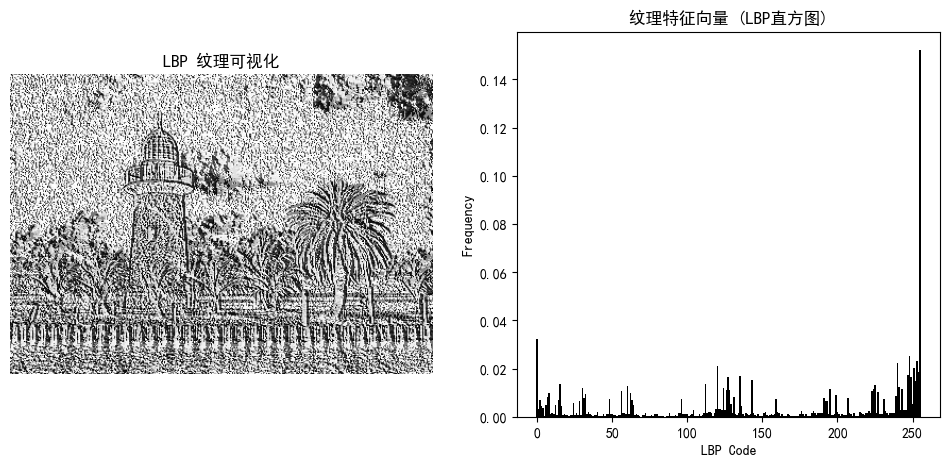

In [8]:
def extract_lbp_feature(gray_img):
    H, W = gray_img.shape
    # LBP 图比原图小一圈
    lbp_map = np.zeros((H-2, W-2), dtype=np.uint8)
    
    # 8邻域权重 (从左上角开始顺时针)
    weights = np.array([1, 2, 4, 8, 16, 32, 64, 128])
    
    for i in range(1, H-1):
        for j in range(1, W-1):
            center = gray_img[i, j]
            # 获取8个邻居
            neighbors = np.array([
                gray_img[i-1, j-1], gray_img[i-1, j], gray_img[i-1, j+1],
                gray_img[i,   j+1],
                gray_img[i+1, j+1], gray_img[i+1, j], gray_img[i+1, j-1],
                gray_img[i,   j-1]
            ])
            # 阈值比较与加权求和
            code = np.sum((neighbors >= center) * weights)
            lbp_map[i-1, j-1] = code
            
    # 计算直方图作为特征向量
    lbp_hist = np.zeros(256, dtype=int)
    for val in lbp_map.reshape(-1):
        lbp_hist[val] += 1
    
    # 归一化 (Probability Distribution)
    feature_vector = lbp_hist / lbp_hist.sum()
    
    return lbp_map, feature_vector

# --- 执行与保存 ---
print("正在提取 LBP 纹理特征...")
lbp_img, lbp_vec = extract_lbp_feature(img_gray)

# 1. 保存纹理特征数据
np.save('texture_features.npy', lbp_vec)
print("特征文件已保存: texture_features.npy")

# 2. 保存 LBP 纹理图
Image.fromarray(lbp_img).save('result_lbp_texture.png')

# 3. 可视化对比
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(lbp_img, cmap='gray')
plt.title("LBP 纹理可视化")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(range(256), lbp_vec, width=1, color='black')
plt.title("纹理特征向量 (LBP直方图)")
plt.xlabel("LBP Code")
plt.ylabel("Frequency")

plt.savefig('result_lbp_analysis.png', dpi=100)
plt.show()